<a href="https://colab.research.google.com/github/luca-arts/luca-arts.github.io/blob/main/Animal_faces_latent_interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Animal faces interpolation

an example notebook to try to interpolate between two insects in latent space.

Based on [Noufals blog](https://medium.com/@noufalsamsudin/latent-space-interpolation-of-images-using-keras-and-tensorflow-js-7e35bec01c5a) & [classification code on Kaggle](https://www.kaggle.com/code/vencerlanz09/insect-classification-using-cnn-mobilenetv2)


In [1]:
!nvidia-smi

Wed Aug 31 08:55:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers import Input, Rescaling, Conv2D, MaxPooling2D, Flatten, Reshape, UpSampling2D, Dense, Dropout, Conv2DTranspose, Activation, LeakyReLU, BatchNormalization
from tensorflow.keras import backend as K

In [23]:
# System libraries
from pathlib import Path
import os.path
import ipywidgets as widgets

In [5]:
# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [6]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## linking GDrive to save models

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
from datetime import date
model_save_name = date.today()
model_path = "/content/gdrive/MyDrive/AI/latent_interpolation/{}".format(model_save_name) 

## hyperparameters

In [9]:
# hyperparameters
resize_factor = 2

BATCH_SIZE = 16
img_orig_height = 512
img_orig_width = 512
img_height = int(img_orig_height/resize_factor)
img_width = int(img_orig_width/resize_factor)
img_dir = '/content/afhq/'
SHAPE=(img_height, img_width)
EPOCHS=12

## helper functions

In [212]:
import math
def plot_conversion(autoencoder, dataset, n):
  encoded_imgs = autoencoder.encoder(dataset[:n]).numpy()
  decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    if(len(dataset[i].shape) > 2 and dataset[i].shape[2]==1):
      plt.imshow(dataset[i].squeeze(2))
    else:
      plt.imshow(dataset[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    if(len(decoded_imgs[i].shape) > 2 and decoded_imgs[i].shape[2]==1):
      plt.imshow(decoded_imgs[i].squeeze(2))
    else:
      plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

def split(l, n):
    # looping till length l
    for i in range(0, len(l), n):
        yield l[i:i + n]
  
#Interpolate
def interpolate_points(p1, p2, n_steps=10, tab=None):
  # linear interpolate vectors
  vectors = list()
  if tab==None:
    # interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
    for ratio in ratios:
      v = (1.0 - ratio) * p1 + ratio * p2
      vectors.append(v)
  else:
    ratio_list = [float(i.value) for i in tab.children]
    chunks = math.ceil(len(p1[0])/len(tab.children))
    p1_chunks = list(split(p1[0], chunks))
    p2_chunks = list(split(p2[0], chunks))
    ratio_arr =  [np.linspace(0,i, num=n_steps) for i in ratio_list]
    ratio_arr = list(zip(*ratio_arr))    
    for i in range(0,n_steps):
        res = np.array([])
        v = np.asarray([(1 - ratio_arr[i][j]) * p1_chunks[j] + ratio_arr[i][j] * p2_chunks[j] for j in range(0,len(tab.children))])
        for i in range(len(v)):
          res = np.concatenate((res,v[i]), axis=None)
        res = np.expand_dims(res, 0)
        vectors.append(res)
  return np.asarray(vectors)

In [186]:
#show interpolations
import random
def show_interpolation(dataset, n_img1, n_img2, encoder, decoder, num_images=10, width=28, height=28, channels=1, tab=None):
  np.random.seed(42)
  img1 = dataset[n_img1].reshape(1,height,width,channels)
  img2 = dataset[n_img2].reshape(1,height,width,channels)
  encoded_img1 = encoder.predict(img1)
  encoded_img2 = encoder.predict(img2)

  interpolated_images=interpolate_points(encoded_img1, encoded_img2, tab=tab)
  interpolated_orig_images=interpolate_points(img1, img2)
  # calculate interpolations
  encoded_images_list = list()
  interpolated_latent_images_list = list()
  interpolated_visual_images_list = list()
  for i, image_idx in enumerate(interpolated_images):
    int_size = int(np.sqrt(len(interpolated_images[i][0])))
    img_size = int(len(interpolated_orig_images[i][0]))
    encoded_images_list.append(interpolated_images[i].reshape(int_size,int_size))
    if channels > 1:
      interpolated_latent_images_list.append(decoder.predict(interpolated_images[i]).reshape(img_size,img_size, channels))
      interpolated_visual_images_list.append(interpolated_orig_images[i].reshape(img_size,img_size, channels))
    else:
      interpolated_latent_images_list.append(decoder.predict(interpolated_images[i]).reshape(img_size,img_size))
      interpolated_visual_images_list.append(interpolated_orig_images[i].reshape(img_size,img_size))

  # plot the interpolations
  plt.figure(figsize=(40, 16))

  for i, image_idx in enumerate(interpolated_images):
      
      ax = plt.subplot(5, num_images, i + 1)
      plt.imshow(encoded_images_list[i])
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      ax.set_title("Encoded: {}".format(i))
      
      ax = plt.subplot(5, num_images,num_images+ i + 1)
      plt.imshow(interpolated_latent_images_list[i])
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      ax.set_title("Latent: {}".format(i))
      
      ax = plt.subplot(5, num_images,2*num_images+ i + 1)
      plt.imshow(interpolated_visual_images_list[i])
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      ax.set_title("Image: {}".format(i))

  plt.show()

In [13]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# first try with mnist dataset

In [14]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
(x_train, _), (x_test, _) = fashion_mnist.load_data()

def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array

x_train = preprocess(x_train)
x_test = preprocess(x_test)
print (x_train.shape)
print (x_test.shape)


4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [15]:
latent_dim = 64 

class mnist_autoencoder(Model):
  def __init__(self, latent_dim):
    super(mnist_autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
mnist_autoencoder = mnist_autoencoder(latent_dim)

In [16]:
mnist_autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.Accuracy(), keras.losses.MeanSquaredError()])

In [17]:
# with example model
hist = mnist_autoencoder.fit(x_train, x_train, validation_data=(x_test, x_test), shuffle=True, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callback])

Epoch 1/12
3750/3750 [==============================] - 14s 3ms/step - loss: 0.3022 - accuracy: 8.5034e-08 - mean_squared_error: 0.0198 - val_loss: 0.2817 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0121
Epoch 2/12
3750/3750 [==============================] - 9s 2ms/step - loss: 0.2764 - accuracy: 3.1888e-07 - mean_squared_error: 0.0109 - val_loss: 0.2768 - val_accuracy: 1.2755e-07 - val_mean_squared_error: 0.0103
Epoch 3/12
3750/3750 [==============================] - 9s 2ms/step - loss: 0.2736 - accuracy: 1.7007e-07 - mean_squared_error: 0.0100 - val_loss: 0.2754 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0099
Epoch 4/12
3750/3750 [==============================] - 9s 2ms/step - loss: 0.2726 - accuracy: 1.7007e-07 - mean_squared_error: 0.0097 - val_loss: 0.2744 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0096
Epoch 5/12
3750/3750 [==============================] - 9s 2ms/step - loss: 0.2721 - accuracy: 1.0629e-07 - mean_squared_error: 0.0096 - val_lo

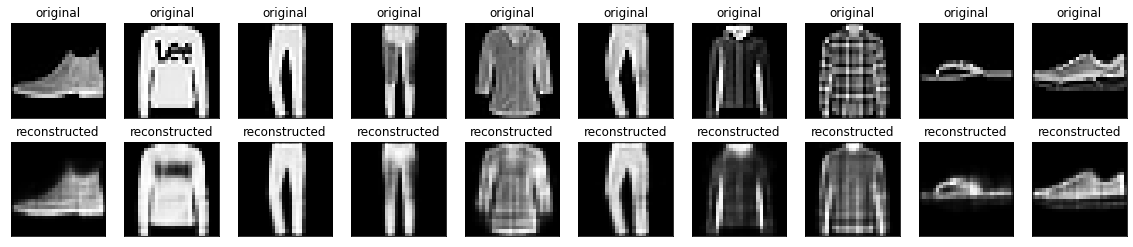

In [20]:
# plot results
plot_conversion(mnist_autoencoder, x_test, 10)

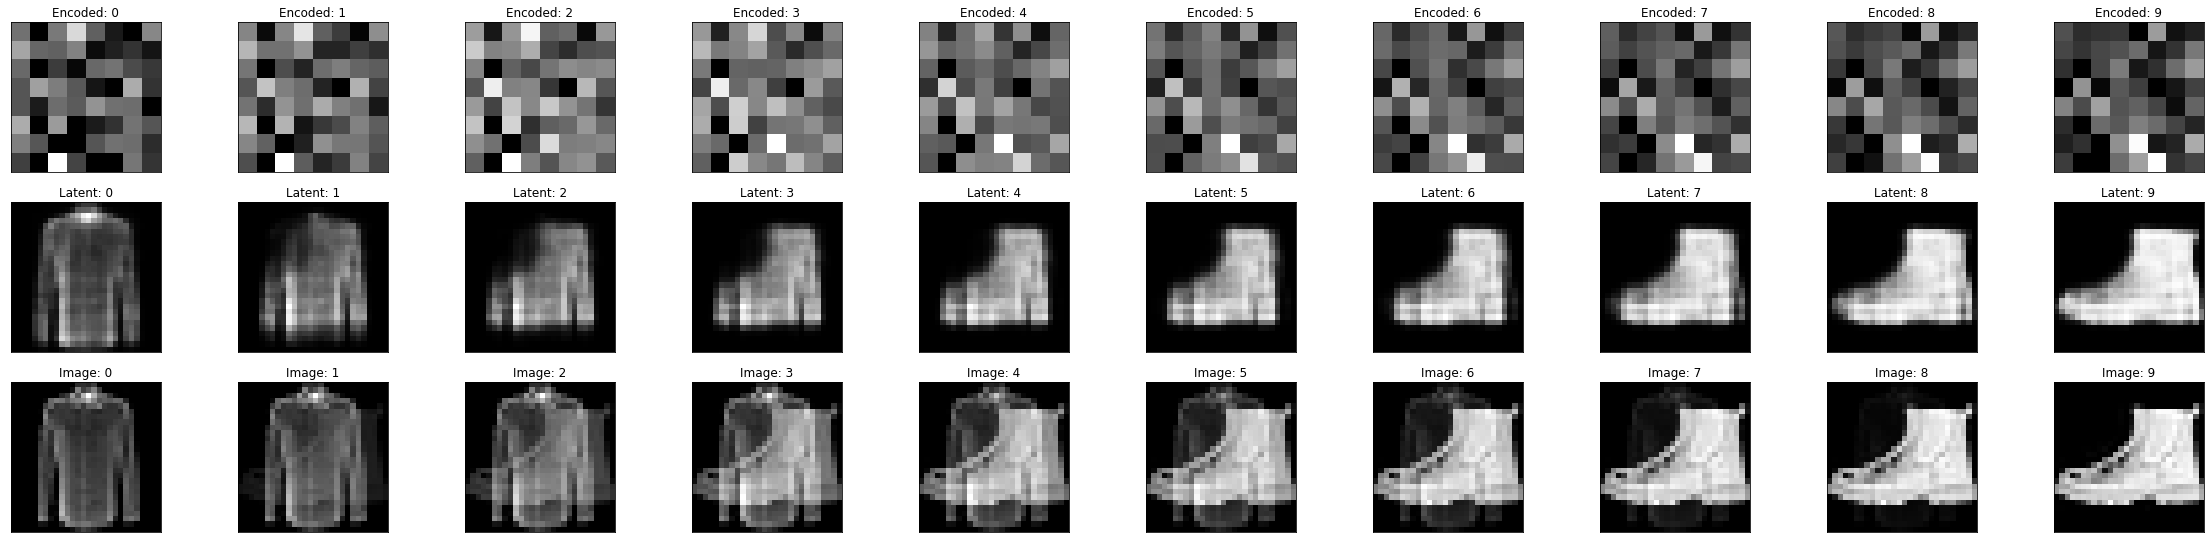

In [21]:
show_interpolation(x_test, mnist_autoencoder.encoder, mnist_autoencoder.decoder, num_images=10)

### use tabbed interpolation

gave a float between 0 and 1 in each tab, the encoded vector will be divided into parts and each part will be interpolated up to the float given for that part. This way we can investigate what each part of the encoding changes

In [189]:
img1_nr = random.randint(0,len(x_test))
img2_nr = random.randint(0,len(x_test))

In [205]:
tab_contents = ['P0', 'P1', 'P2', 'P3', 'P4']
children = [widgets.Text(description=name) for name in tab_contents]
tab = widgets.Tab()
tab.children = children
tab.titles = [str(i) for i in range(len(children))]
for i in range(len(children)):
  tab.children[i].value = str(1.0)
tab

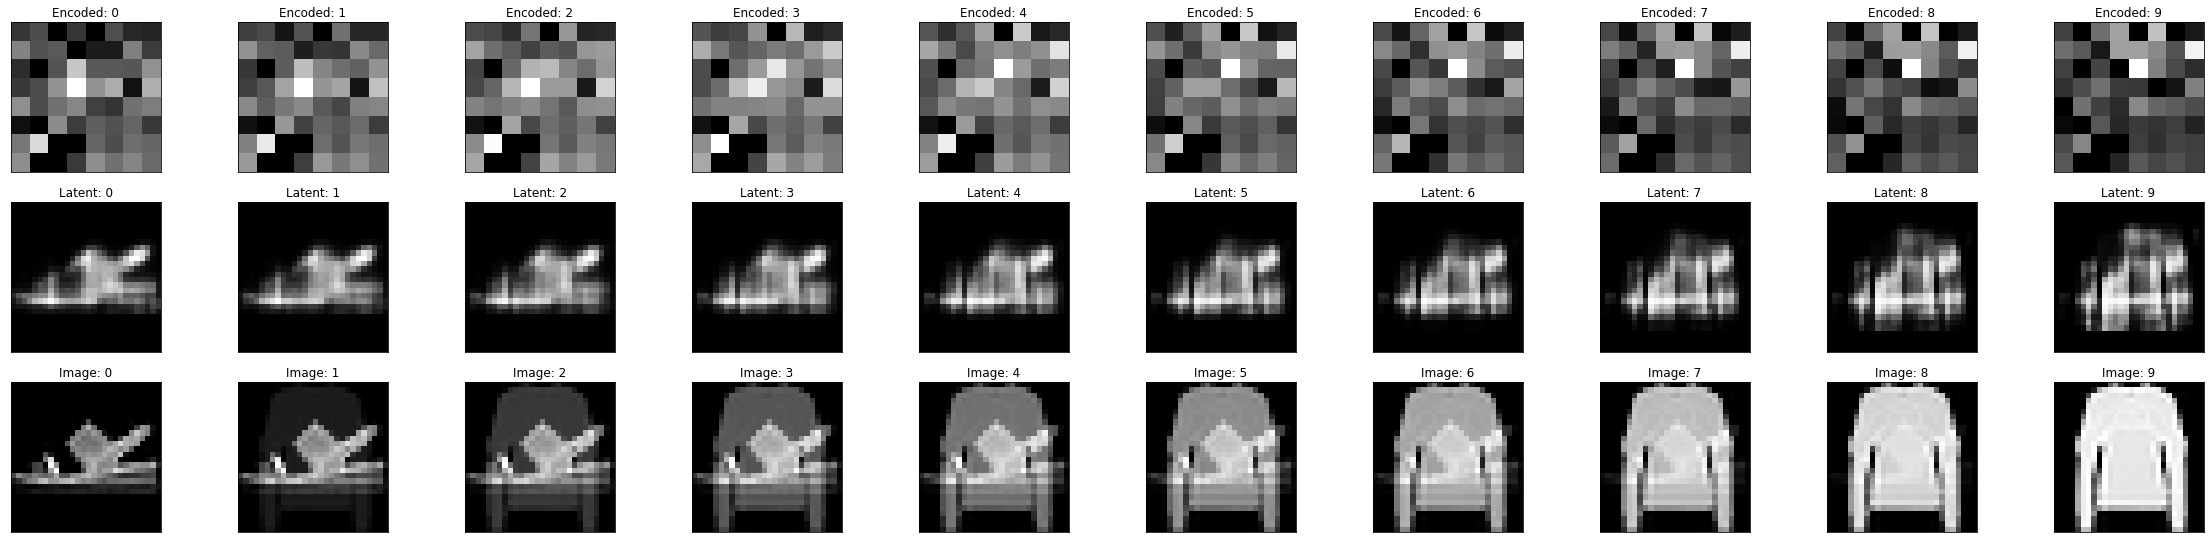

In [245]:
show_interpolation(x_test, img1_nr, img2_nr, mnist_autoencoder.encoder, mnist_autoencoder.decoder, num_images=10, tab=tab)

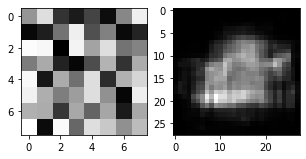

In [243]:
## let's create a random plot
random_vector = np.random.rand(1,64)
random_img = mnist_autoencoder.decoder.predict(random_vector).reshape(28,28)

plt.figure(figsize=(5, 5))
ax = plt.subplot(1,2, 1)
plt.imshow(random_vector.reshape(8,8))
plt.gray()
ax = plt.subplot(1,2,2)
plt.imshow(random_img)
plt.gray()
plt.show()

## use a CNN for mnist fashion

In [ ]:
class mnist_autoencoder2(Model):
  def __init__(self):
    super(mnist_autoencoder2, self).__init__()
    self.encoder = tf.keras.Sequential([
      Input(shape=(28,28,1)),
      Conv2D(64,(3,3), activation='relu', padding='same', strides=2),
      MaxPooling2D((2, 2), padding='same'),    
      Flatten()  
    ])
    self.decoder = tf.keras.Sequential([
      Reshape((28,28,-1), input_shape=(28*28*4,)),
      Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
      Conv2D(1,(3, 3), activation='relu', padding='same', strides=2)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
mnist_autoencoder2 = mnist_autoencoder2()

In [ ]:
mnist_autoencoder2.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.Accuracy(), keras.losses.MeanSquaredError()])

In [ ]:
mnist_autoencoder2.encoder.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 3136)              0         
                                                                 
Total params: 640
Trainable params: 640
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mnist_autoencoder2.decoder.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 28, 28, 4)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 56, 56, 64)       2368      
 ranspose)                                                       
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 1)         577       
                                                                 
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = mnist_autoencoder2.fit(x_train, x_train, validation_data=(x_test, x_test), shuffle=True, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callback])

Epoch 1/12
1875/1875 [==============================] - 14s 7ms/step - loss: 0.4762 - accuracy: 0.0510 - mean_squared_error: 0.0794 - val_loss: 0.4530 - val_accuracy: 0.1039 - val_mean_squared_error: 0.0710
Epoch 2/12
1875/1875 [==============================] - 13s 7ms/step - loss: 0.4521 - accuracy: 0.0867 - mean_squared_error: 0.0707 - val_loss: 0.4451 - val_accuracy: 0.1089 - val_mean_squared_error: 0.0678
Epoch 3/12
1875/1875 [==============================] - 13s 7ms/step - loss: 0.4460 - accuracy: 0.0869 - mean_squared_error: 0.0686 - val_loss: 0.4405 - val_accuracy: 0.0794 - val_mean_squared_error: 0.0665
Epoch 4/12
1875/1875 [==============================] - 14s 7ms/step - loss: 0.4387 - accuracy: 0.0969 - mean_squared_error: 0.0660 - val_loss: 0.4402 - val_accuracy: 0.0975 - val_mean_squared_error: 0.0661
Epoch 5/12
1875/1875 [==============================] - 14s 7ms/step - loss: 0.4358 - accuracy: 0.1027 - mean_squared_error: 0.0648 - val_loss: 0.4365 - val_accuracy: 0.091

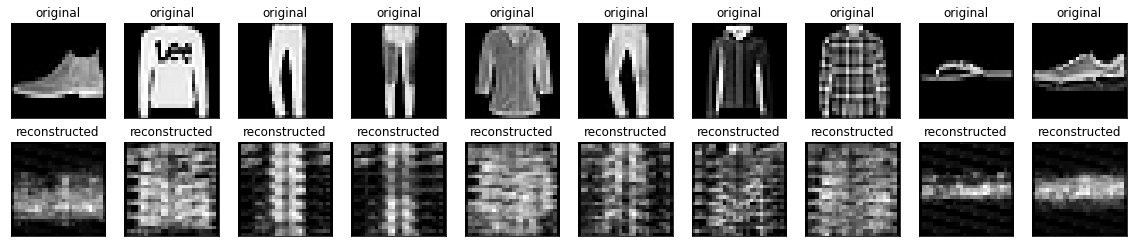

In [ ]:
# plot results
plot_conversion(mnist_autoencoder2, x_test, 10)

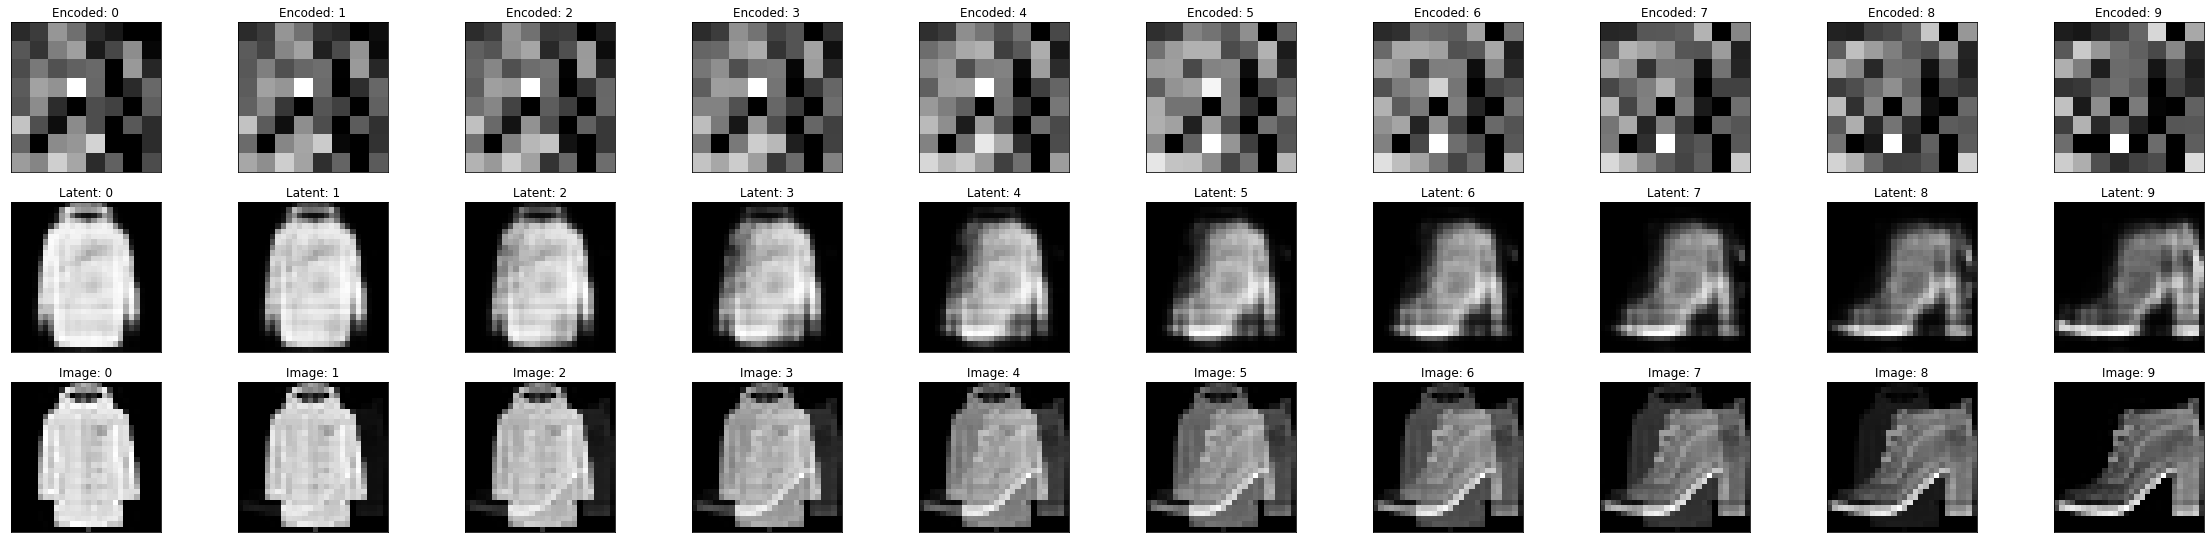

In [ ]:
show_interpolation(x_test, mnist_autoencoder.encoder, mnist_autoencoder.decoder, num_images=10)

# Kaggle dataset

## downloading the Kaggle dataset

Make sure you upload your Kaggle API key JSON file here. (via Kaggle, profile, Account)

Via [link](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/)

In [ ]:
dataset_name = "andrewmvd/animal-faces"
dataset = "animal-faces"

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download {dataset_name}
!unzip -qq {dataset}.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
unzip:  cannot find or open animal-faces.zip, animal-faces.zip.zip or animal-faces.zip.ZIP.


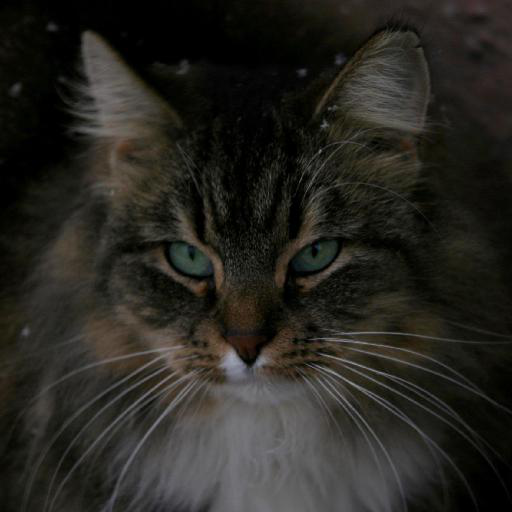

In [ ]:
test_img = keras.utils.load_img('/content/afhq/train/cat/flickr_cat_000002.jpg')
test_img

Found 14630 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


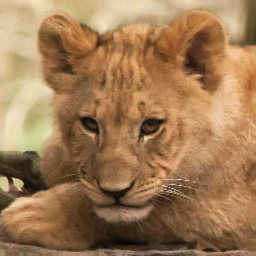

In [ ]:
## load data with imagedatagenerator
image_generator = ImageDataGenerator(
    rescale=1.0 / 255,
    # vertical_flip=True,
    rotation_range=10,
    # zoom_range=10.0,
    # width_shift_range=0.2,
    # height_shift_range=0.2,

    )
train_gen = image_generator.flow_from_directory(
    os.path.join(img_dir, "train"), 
    class_mode="input", target_size=SHAPE, batch_size=BATCH_SIZE,
)
val_gen = image_generator.flow_from_directory(
    os.path.join(img_dir, "val"), 
    class_mode="input", target_size=SHAPE, batch_size=BATCH_SIZE,
)
for image, label in train_gen:
  img = keras.preprocessing.image.array_to_img(image[0])
  break
img

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=6)

In [ ]:
for image_batch in train_gen:
  print(image_batch[0].shape)
  print(image_batch[0].shape[1:])

  # print(labels_batch.shape)
  break

(16, 256, 256, 3)
(256, 256, 3)


In [ ]:
# auto-encoder model
input=Input(shape=image_batch[0].shape[1:])
encoded = keras.layers.Rescaling(1./255)(input)
encoded=Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(encoded)
encoded=MaxPooling2D((2, 2), padding='same')(encoded)
encoded=Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(encoded)
encoded=MaxPooling2D((2, 2), padding='same')(encoded)
encoded=Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(encoded)
encoded=Flatten()(encoded)

decoded=Reshape((int(64/resize_factor),int(64/resize_factor),-1))(encoded)#(32, 32, 32))(encoded)
decoded = Conv2DTranspose(64, kernel_size=3,strides=2, activation='relu',padding='same')(decoded)
decoded = Conv2DTranspose(64, kernel_size=3,strides=2, activation='relu',padding='same')(decoded)
decoded = Conv2DTranspose(128, kernel_size=3,strides=2, activation='relu',padding='same')(decoded)
decoded=Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded)
        
autoencoder=Model(input,decoded)
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 512, 512, 3)]     0         
                                                                 
 rescaling_7 (Rescaling)     (None, 512, 512, 3)       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 256, 256, 128)     3584      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 128, 128, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 64, 64, 64)        73792     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                      

In [ ]:
#compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.Accuracy()])

In [ ]:
hist = autoencoder.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callback])

Epoch 1/12
915/915 [==============================] - 825s 898ms/step - loss: 0.6855 - accuracy: 4.8846e-08 - val_loss: 0.6848 - val_accuracy: 5.0015e-08
Epoch 2/12
915/915 [==============================] - 820s 896ms/step - loss: 0.6854 - accuracy: 4.9281e-08 - val_loss: 0.6849 - val_accuracy: 2.6279e-08
Epoch 3/12
915/915 [==============================] - 811s 887ms/step - loss: 0.6854 - accuracy: 4.6326e-08 - val_loss: 0.6849 - val_accuracy: 3.8147e-08
Epoch 4/12
915/915 [==============================] - 808s 883ms/step - loss: 0.6853 - accuracy: 4.9628e-08 - val_loss: 0.6850 - val_accuracy: 5.1710e-08
Epoch 5/12
915/915 [==============================] - 808s 883ms/step - loss: 0.6853 - accuracy: 5.0932e-08 - val_loss: 0.6849 - val_accuracy: 5.0015e-08
Epoch 6/12
915/915 [==============================] - 807s 881ms/step - loss: 0.6853 - accuracy: 4.5804e-08 - val_loss: 0.6848 - val_accuracy: 6.3578e-08
Epoch 7/12
210/915 [=====>........................] - ETA: 9:26 - loss: 0.68

KeyboardInterrupt: ignored

In [ ]:
autoencoder.save(os.path.join(model_path,"autoencoder"))

## more flexible model

Based on [PyImageSearchs blog](https://pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/)

In [ ]:
class FlexAutoencoder(Model):
  def __init__(self, width, height, depth, filters=(32, 64), latentDim=16):
    super(FlexAutoencoder, self).__init__()
    # initialize the input shape to be "channels last" along with
    # the channels dimension itself
    # channels dimension itself
    inputShape = (height, width, depth)
    chanDim = -1


    # define the input to the encoder
    self.inputs = Input(shape=inputShape)
    x = self.inputs
    # loop over the number of filters
    for f in filters:
      # apply a CONV => RELU => BN operation
      x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
      x = LeakyReLU(alpha=0.2)(x)
      x = BatchNormalization(axis=chanDim)(x)
    # flatten the network and then construct our latent vector
    volumeSize = K.int_shape(x)
    x = Flatten()(x)
    latent = Dense(latentDim)(x)
    # build the encoder model
    self.encoder = Model(self.inputs, latent, name="encoder")

    # start building the decoder model which will accept the
    # output of the encoder as its inputs
    latentInputs = Input(shape=(latentDim,))
    x = Dense(np.prod(volumeSize[1:]))(latentInputs)
    x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
    # loop over our number of filters again, but this time in
    # reverse order
    for f in filters[::-1]:
      # apply a CONV_TRANSPOSE => RELU => BN operation
      x = Conv2DTranspose(f, (3, 3), strides=2,
        padding="same")(x)
      x = LeakyReLU(alpha=0.2)(x)
      x = BatchNormalization(axis=chanDim)(x)
   

    # apply a single CONV_TRANSPOSE layer used to recover the
    # original depth of the image
    x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
    outputs = Activation("sigmoid")(x)
    # build the decoder model
    self.decoder = Model(latentInputs, outputs, name="decoder")

  def call(self, x):
    encoded = self.encoder(x)
    autoencoder = self.decoder(encoded)
    return autoencoder

In [ ]:
# if OOM:
import gc
keras.backend.clear_session()
gc.collect()
# del autoencoder

4748

In [ ]:
flex_autoencoder = FlexAutoencoder(img_width, img_height, 3, filters=(256, 128, 64), latentDim=40*40)

In [ ]:
flex_autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.Accuracy(), keras.losses.MeanSquaredError()])

In [ ]:
hist = flex_autoencoder.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callback])

Epoch 1/12
915/915 [==============================] - 488s 533ms/step - loss: 0.5944 - accuracy: 1.2829e-07 - mean_squared_error: 0.0195 - val_loss: 0.5811 - val_accuracy: 1.4920e-07 - val_mean_squared_error: 0.0142
Epoch 2/12
915/915 [==============================] - 488s 533ms/step - loss: 0.5773 - accuracy: 1.8947e-07 - mean_squared_error: 0.0125 - val_loss: 0.5714 - val_accuracy: 1.9328e-07 - val_mean_squared_error: 0.0101
Epoch 3/12
915/915 [==============================] - 488s 533ms/step - loss: 0.5718 - accuracy: 1.8600e-07 - mean_squared_error: 0.0102 - val_loss: 0.5674 - val_accuracy: 2.1023e-07 - val_mean_squared_error: 0.0085
Epoch 4/12
915/915 [==============================] - 488s 533ms/step - loss: 0.5687 - accuracy: 1.9990e-07 - mean_squared_error: 0.0089 - val_loss: 0.5675 - val_accuracy: 1.3563e-07 - val_mean_squared_error: 0.0084
Epoch 5/12
915/915 [==============================] - 487s 532ms/step - loss: 0.5666 - accuracy: 2.1068e-07 - mean_squared_error: 0.0081

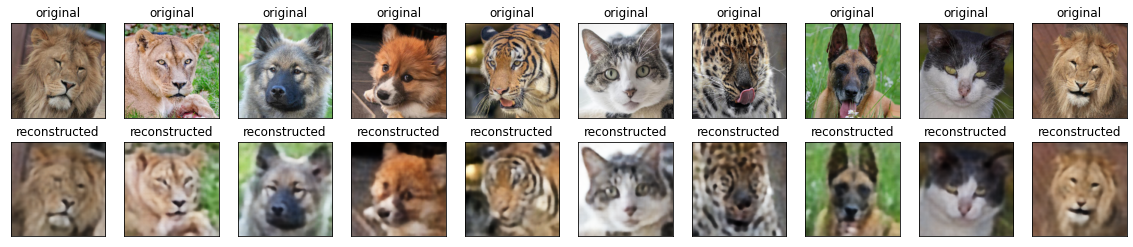

In [ ]:
# plot results
plot_conversion(flex_autoencoder, val_gen.next()[0], 10)

In [ ]:
flex_autoencoder.save(os.path.join(model_path,"flex_autoencoder"))

#### show the interpolation

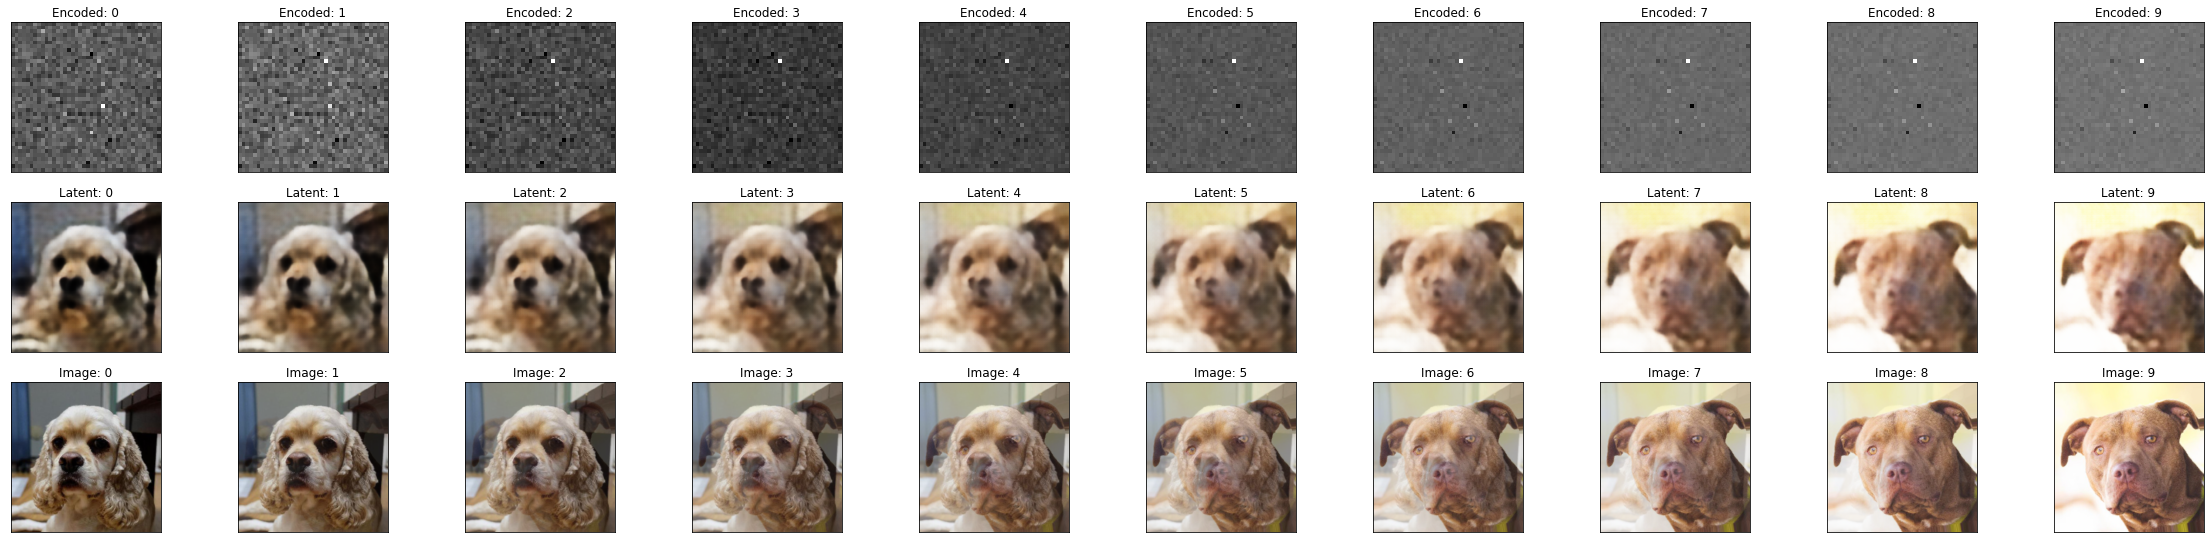

In [ ]:
show_interpolation(val_gen.next()[0], flex_autoencoder.encoder, flex_autoencoder.decoder, num_images=10, height=img_height, width=img_width, channels=3)

# load the model

In [ ]:
gdrive_origin = Path("/content/gdrive/MyDrive/AI/latent_interpolation")
model_list = list()
for i in os.listdir(gdrive_origin):
  print("folder found: {}".format(i))
  model_list.append(i)

In [ ]:
autoencoder = keras.models.load_model(os.path.join(gdrive_origin,model_list[0],"autoencoder"))

In [ ]:
encoder = Model(inputs=autoencoder.input, outputs = autoencoder.layers[6].output)
encoder.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_57 (Conv2D)          (None, 64, 64, 512)       14336     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 32, 32, 512)      0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 16, 16, 128)       589952    
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 4, 4, 64)          737

In [ ]:
encoded_input = Input(shape=(1024,))

# deco = autoencoder.layers[-8](encoded_input)
# deco = autoencoder.layers[-7](deco)
# deco = autoencoder.layers[-6](deco)
deco = autoencoder.layers[-5](encoded_input)
deco = autoencoder.layers[-4](deco)
deco = autoencoder.layers[-3](deco)
deco = autoencoder.layers[-2](deco)
deco = autoencoder.layers[-1](deco)
# create the decoder model
decoder = Model(encoded_input, deco)
decoder.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 1024)]            0         
                                                                 
 reshape_10 (Reshape)        (None, 16, 16, 4)         0         
                                                                 
 conv2d_transpose_11 (Conv2D  (None, 32, 32, 64)       2368      
 Transpose)                                                      
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 64, 64, 128)      73856     
 Transpose)                                                      
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 128, 128, 512)    590336    
 Transpose)                                                      
                                                          

In [ ]:
len(autoencoder.layers),len(encoder.layers),len(decoder.layers)

(15, 7, 9)

# try out basic inference

In [ ]:
predict_res = autoencoder.predict(val_gen)

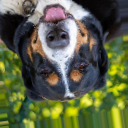

In [ ]:
for image in predict_res:
  pred_img = keras.preprocessing.image.array_to_img(image)
  break
# 2. pick an image from val_gen
for image, label in val_gen:
  inf_img = keras.preprocessing.image.array_to_img(image[0])
  break
inf_img

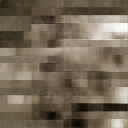

In [ ]:
pred_img

## interpolation

In [ ]:
def pick_test_images(ds):
  # Randomly pick two images and generate their encodings
  import random
  img1 = ds[0][0][random.randint(0,63)].reshape(1,int(img_height/resize_factor), int(img_width/resize_factor), 3)
  img2 = ds[0][0][random.randint(0,63)].reshape(1,int(img_height/resize_factor), int(img_width/resize_factor), 3)
  return img1, img2
test_image1, test_image2 = pick_test_images(val_gen)

NameError: ignored

In [ ]:
#predict encodings
encoded_img1 = encoder.predict(test_image1)
encoded_img2 = encoder.predict(test_image2)

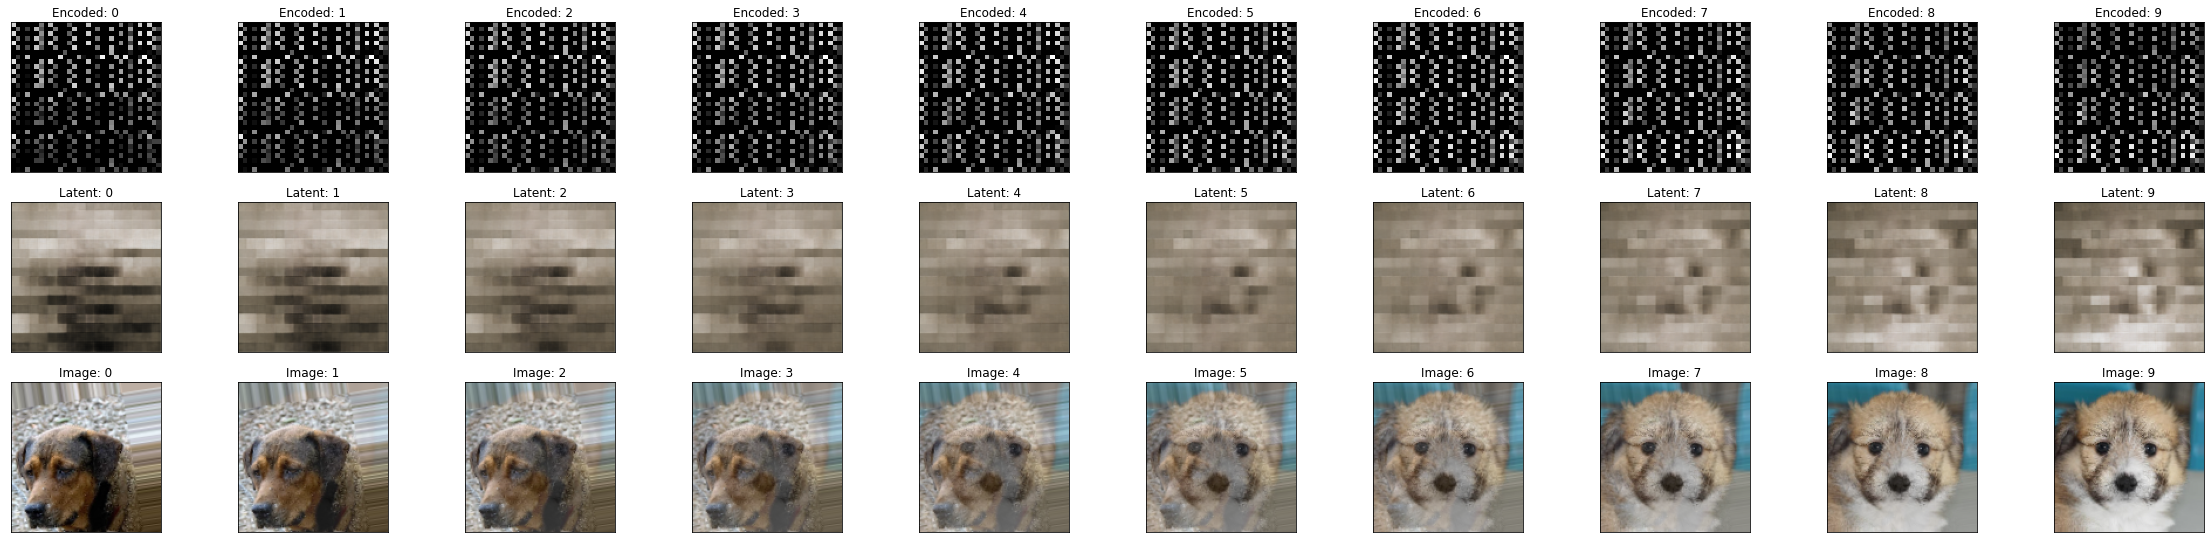

In [ ]:
interpolated_images=interpolate_points(encoded_img1.flatten(),encoded_img2.flatten())
interpolated_orig_images=interpolate_points(test_image1.flatten(),test_image2.flatten())

interpolated_images.shape
num_images = 10
np.random.seed(42)
plt.figure(figsize=(40, 16))

for i, image_idx in enumerate(interpolated_images):
    
    ax = plt.subplot(5, num_images, i + 1)
    plt.imshow(interpolated_images[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Encoded: {}".format(i))
    
    ax = plt.subplot(5, num_images,num_images+ i + 1)
    plt.imshow(decoder.predict(interpolated_images[i].reshape(1,1024)).reshape(128,128,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Latent: {}".format(i))
    
    ax = plt.subplot(5, num_images,2*num_images+ i + 1)
    plt.imshow(interpolated_orig_images[i].reshape(128,128,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Image: {}".format(i))

plt.show()